# **Installing necessary libraries**

In [2]:
#Downloading libraries

%pip install catboost optuna seaborn scikit-learn openpyxl nbformat ipython ipywidgets lazypredict-nightly

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Importing libraries and setting necessery settings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
import optuna
from optuna.samplers import TPESampler
import lazypredict
from lazypredict import LazyRegressor
from catboost import CatBoostRegressor, Pool, cv
from pandas.api.types import is_numeric_dtype
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder, MaxAbsScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.utils import shuffle


%matplotlib inline
plt.style.use("seaborn-v0_8")

# **Basic EDA**

In [12]:
# Readign the file

data = pd.read_excel("Employee Turnover Analytics Data set.xlsx")

In [5]:
# To view some real data

data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [6]:
# To understand the statistica about the data

data.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.00,14999.00,14999.00,14999.00,14999.00,14999.00,14999.00,14999.00
mean,0.61,0.72,3.80,201.05,3.50,0.14,0.24,0.02
std,0.25,0.17,1.23,49.94,1.46,0.35,0.43,0.14
min,0.09,0.36,2.00,96.00,2.00,0.00,0.00,0.00
25%,0.44,0.56,3.00,156.00,3.00,0.00,0.00,0.00
50%,0.64,0.72,4.00,200.00,3.00,0.00,0.00,0.00
75%,0.82,0.87,5.00,245.00,4.00,0.00,0.00,0.00
max,1.00,1.00,7.00,310.00,10.00,1.00,1.00,1.00


In [7]:
# To know data types and null number

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   sales                  14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [13]:
# Drop unnecessary columns and For further simplicity the target row should be the last

data.drop(["left", "promotion_last_5years"], axis = 1, inplace = True)

cols = data.columns.tolist()
cols = cols[1:] + cols[:1]
data = data[cols]

In [9]:
# Check

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   last_evaluation       14999 non-null  float64
 1   number_project        14999 non-null  int64  
 2   average_montly_hours  14999 non-null  int64  
 3   time_spend_company    14999 non-null  int64  
 4   Work_accident         14999 non-null  int64  
 5   sales                 14999 non-null  object 
 6   salary                14999 non-null  object 
 7   satisfaction_level    14999 non-null  float64
dtypes: float64(2), int64(4), object(2)
memory usage: 937.6+ KB


In [14]:
df = shuffle(data, random_state = 777)
df

,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,sales,salary,satisfaction_level
6118,0.87,4,194,4,0,sales,low,0.15
13064,0.38,4,203,5,0,sales,low,0.58
14710,0.95,2,181,5,0,technical,medium,0.89
10564,0.89,5,182,2,0,hr,low,0.74
720,0.49,2,139,3,0,hr,low,0.42
...,...,...,...,...,...,...,...,...
10311,0.62,4,233,3,0,marketing,medium,0.61
4017,0.91,4,186,3,0,support,low,0.69
7767,0.65,4,134,3,0,technical,medium,0.68
2982,0.71,3,181,2,0,technical,low,0.64


In [15]:
# Creating the target and feature lists

target = "satisfaction_level"
df_features = [col for col in df.columns if col != target]

In [16]:
# Encoding the categorical features for some models

categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
one_hot_encoded = encoder.fit_transform(df[categorical_columns])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))
df_encoded = pd.concat([df, one_hot_df], axis=1)
df_encoded = df_encoded.drop(categorical_columns, axis=1)

In [17]:
# Creating the target and feature lists for encoded dataset

df_encoded_features = [col for col in df_encoded.columns if col != target]
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14999 entries, 6118 to 14439
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   last_evaluation       14999 non-null  float64
 1   number_project        14999 non-null  int64  
 2   average_montly_hours  14999 non-null  int64  
 3   time_spend_company    14999 non-null  int64  
 4   Work_accident         14999 non-null  int64  
 5   satisfaction_level    14999 non-null  float64
 6   sales_IT              14999 non-null  float64
 7   sales_RandD           14999 non-null  float64
 8   sales_accounting      14999 non-null  float64
 9   sales_hr              14999 non-null  float64
 10  sales_management      14999 non-null  float64
 11  sales_marketing       14999 non-null  float64
 12  sales_product_mng     14999 non-null  float64
 13  sales_sales           14999 non-null  float64
 14  sales_support         14999 non-null  float64
 15  sales_technical      

In [18]:
# Getting categorical feature indecies from main dataset

def get_categorical_indicies(X):
    cats = []
    for col in X.columns:
        if is_numeric_dtype(X[col]):
            pass
        else:
            cats.append(col)
    cat_indicies = []
    for col in cats:
        cat_indicies.append(X.columns.get_loc(col))
    return cat_indicies


categorical_indicies = get_categorical_indicies(df)

# **Searching for the best model**

In [28]:
# Building 40+ regressors

X_train, X_test, y_train, y_test = train_test_split(df[df_features], df[target],
                                                        test_size = 0.25,
                                                        random_state = 777)

reg = LazyRegressor(ignore_warnings = False)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

100%|██████████| 42/42 [01:36<00:00,  2.31s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 327
[LightGBM] [Info] Number of data points in the train set: 11249, number of used features: 18
[LightGBM] [Info] Start training from score 0.611764


In [29]:
# Searching for the best regressors

predictions["RMSE"].map(lambda x: '%.4f' % x)

Model
RandomForestRegressor             0.1720
ExtraTreesRegressor               0.1727
LGBMRegressor                     0.1776
HistGradientBoostingRegressor     0.1792
BaggingRegressor                  0.1800
XGBRegressor                      0.1805
GradientBoostingRegressor         0.1817
NuSVR                             0.1862
SVR                               0.1863
MLPRegressor                      0.1889
AdaBoostRegressor                 0.1943
KNeighborsRegressor               0.1961
DecisionTreeRegressor             0.2263
ExtraTreeRegressor                0.2299
SGDRegressor                      0.2384
OrthogonalMatchingPursuitCV       0.2385
ElasticNetCV                      0.2385
LassoLarsCV                       0.2385
LarsCV                            0.2385
LassoCV                           0.2385
LassoLarsIC                       0.2385
BayesianRidge                     0.2385
RidgeCV                           0.2385
Ridge                             0.2385
Lars      

In [32]:
# Building CatBoostRegressor for comparison

model = CatBoostRegressor(
    cat_features = categorical_indicies,
)


model.fit(X_train, y_train, eval_set = [(X_test, y_test)],
            verbose = False)
preds = model.predict(X_test)
rmse = root_mean_squared_error(y_test, preds)
rmse

0.17945812345786055

In [172]:
# Building NeuralNetworkRegressor for comparison

X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(df_encoded[df_encoded_features], df_encoded[target],
                                                        test_size = 0.25,
                                                        random_state = 777)

mlp = MLPRegressor()
mlp.fit(X_train_enc, y_train_enc)
rmse_mplp = root_mean_squared_error(y_test_enc, mlp.predict(X_test_enc))
rmse_mplp

0.2394632204765995

# **RandomForest**

In [151]:
# RandomForest hyperparameters search using optuna

def objective(trial):
    # split data in training and test data
    X_train, X_test, y_train, y_test = train_test_split(df_encoded[df_encoded_features], df_encoded[target],
                                                        test_size=0.25,
                                                        random_state=777)

    # Instantiate scaler
    scalers = trial.suggest_categorical("scalers", ['minmax', 'standard', 'robust', 'maxabs', None])

    if scalers == "minmax":
        scaler = MinMaxScaler()
    elif scalers == "standard":
        scaler = StandardScaler()
    elif scalers == 'maxabs':
        scaler = MaxAbsScaler()
    elif scalers == 'robust':
        scaler = RobustScaler()
    else:
        scaler = None
    

    # Suggest hyperparameters
    param = { 
        "n_estimators": trial.suggest_int('n_estimators', 50, 1000),
        "max_depth": trial.suggest_int('max_depth', 10, 150),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
   } 
     
    rfr = RandomForestRegressor(
        random_state = 777,
        criterion = 'friedman_mse',
        **param)

    # Make a pipeline
    pipeline = make_pipeline(scaler, rfr)
    pipeline.fit(X_train, y_train)


    # Predict and estimate results
    preds = pipeline.predict(X_test)
    rmse = root_mean_squared_error(y_test, preds)

    return rmse

# Opruna study creation for tuning
sampler_rfr = TPESampler(multivariate = True, group = True, seed = 777)
study_rfr = optuna.create_study(study_name = "RFR", sampler = sampler_rfr)
study_rfr.optimize(objective, n_trials = 150)
trial_rfr = study_rfr.best_trial
params_rfr = study_rfr.best_trial.params

# Printing the parameters
print("Number of finished trials: ", len(study_rfr.trials))
print("Best trial:", trial_rfr.number)
print("  Value: ", trial_rfr.value)
print("  Params: ")

for key, value in trial_rfr.params.items():
    print("    {}: {}".format(key, value))

[I 2024-05-19 23:41:49,685] A new study created in memory with name: RFR
[I 2024-05-19 23:42:05,204] Trial 0 finished with value: 0.17074813686866802 and parameters: {'scalers': None, 'n_estimators': 931, 'max_depth': 112, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.17074813686866802.
[I 2024-05-19 23:42:16,476] Trial 1 finished with value: 0.17090043803856325 and parameters: {'scalers': None, 'n_estimators': 645, 'max_depth': 106, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.17074813686866802.
[I 2024-05-19 23:42:54,998] Trial 2 finished with value: 0.17155806344955274 and parameters: {'scalers': None, 'n_estimators': 889, 'max_depth': 97, 'max_features': None}. Best is trial 0 with value: 0.17074813686866802.
[I 2024-05-19 23:42:56,152] Trial 3 finished with value: 0.17127297651233828 and parameters: {'scalers': 'maxabs', 'n_estimators': 62, 'max_depth': 83, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.17074813686866802.
[I 2024-05-19 23:43:06,515] Tria

Number of finished trials:  150
Best trial: 137
  Value:  0.17039856088432723
  Params: 
    scalers: minmax
    n_estimators: 890
    max_depth: 27
    max_features: log2


In [152]:
# History of optimization

optuna.visualization.plot_optimization_history(study_rfr)

In [153]:
# Hyperparameters to score dependency

optuna.visualization.plot_slice(study_rfr)

In [154]:
# Hyperparameter importances

optuna.visualization.plot_param_importances(study_rfr)

In [155]:
# Define optimal hyperparameters
del params_rfr['scalers']
scaler_rfr = MinMaxScaler()
rfr = RandomForestRegressor(**params_rfr, criterion = 'friedman_mse')

# Create pipeline
pipeline_rfr = make_pipeline(scaler_rfr, rfr)

In [156]:
# Implementing cross validation

scores_rfr = cross_val_score(pipeline_rfr, df_encoded[df_encoded_features], df_encoded[target],  scoring = 'neg_root_mean_squared_error') * (-1)
score_mean_rfr = scores_rfr.mean()
print(scores_rfr, "Средняя оценка:", score_mean_rfr)

[0.1453414  0.20959767 0.20842707 0.16439386 0.06375362] Средняя оценка: 0.15830272347743563


# **KNN**

In [177]:
# KNN hyperparameters search using optuna


def objective(trial):
    # split data in training and test data
    X_train, X_test, y_train, y_test = train_test_split(df_encoded[df_encoded_features], df_encoded[target],
                                                        test_size=0.25,
                                                        random_state=777)

    # Instantiate scaler
    scalers = trial.suggest_categorical("scalers", ['minmax', 'standard', 'robust', 'maxabs', None])

    if scalers == "minmax":
        scaler = MinMaxScaler()
    elif scalers == "standard":
        scaler = StandardScaler()
    elif scalers == 'maxabs':
        scaler = MaxAbsScaler()
    elif scalers == 'robust':
        scaler = RobustScaler()
    else:
        scaler = None

    # Suggest hyperparameters
    param = { 
        'n_neighbors': trial.suggest_int("n_neighbors", 1, 500),
        'weights': trial.suggest_categorical("weights", ['uniform', 'distance']),
        'metric': trial.suggest_categorical("metric", ['euclidean', 'manhattan', 'minkowski',
                                                        'cityblock', 'l1', 'l2']),
        'algorithm': trial.suggest_categorical("algorithm", ['ball_tree', 'kd_tree', 'brute']),
    }
    
    if param["algorithm"] != "brute":
        param["leaf_size"] = trial.suggest_int('leaf_size', 1, 150)

    knn = KNeighborsRegressor(**param)
    
    # Make a pipeline
    pipeline = make_pipeline(scaler, knn)
    pipeline.fit(X_train, y_train)


    # Predict and estimate results
    preds = pipeline.predict(X_test)
    rmse = root_mean_squared_error(y_test, preds)

    return rmse


# Opruna study creation for tuning
sampler_knn = TPESampler(multivariate = True, group = True, seed = 777)
study_knn = optuna.create_study(study_name = "knn", sampler = sampler_knn)
study_knn.optimize(objective, n_trials = 150)
trial_knn = study_knn.best_trial
params_knn = study_knn.best_trial.params

# Printing the parameters
print("Number of finished trials: ", len(study_knn.trials))
print("Best trial:", trial_knn.number)
print("  Value: ", trial_knn.value)
print("  Params: ")

for key, value in trial_knn.params.items():
    print("    {}: {}".format(key, value))

[I 2024-05-20 00:22:25,752] A new study created in memory with name: knn
[I 2024-05-20 00:22:26,424] Trial 0 finished with value: 0.18051505540109108 and parameters: {'scalers': None, 'n_neighbors': 464, 'weights': 'distance', 'metric': 'manhattan', 'algorithm': 'ball_tree', 'leaf_size': 83}. Best is trial 0 with value: 0.18051505540109108.
[I 2024-05-20 00:22:26,809] Trial 1 finished with value: 0.1753951242792008 and parameters: {'scalers': None, 'n_neighbors': 97, 'weights': 'distance', 'metric': 'cityblock', 'algorithm': 'kd_tree', 'leaf_size': 2}. Best is trial 1 with value: 0.1753951242792008.
[I 2024-05-20 00:22:28,355] Trial 2 finished with value: 0.23316065386800147 and parameters: {'scalers': 'standard', 'n_neighbors': 307, 'weights': 'uniform', 'metric': 'l2', 'algorithm': 'kd_tree', 'leaf_size': 52}. Best is trial 1 with value: 0.1753951242792008.
[I 2024-05-20 00:22:29,491] Trial 3 finished with value: 0.22275010662294664 and parameters: {'scalers': 'maxabs', 'n_neighbors'

Number of finished trials:  150
Best trial: 116
  Value:  0.1692049667546559
  Params: 
    scalers: robust
    n_neighbors: 210
    weights: distance
    metric: l1
    algorithm: brute


In [178]:
# History of optimization

optuna.visualization.plot_optimization_history(study_knn)

In [179]:
# Hyperparameters to score dependency

optuna.visualization.plot_slice(study_knn)

In [180]:
# Hyperparameter importances

optuna.visualization.plot_param_importances(study_knn)

In [181]:
# Extracting hyperparameters
del params_knn['scalers']

# Define optimal hyperparameters
scaler_knn = RobustScaler()
knn = KNeighborsRegressor(**params_knn)

# Create pipeline
pipeline_knn = make_pipeline(scaler_knn, knn)

In [182]:
# Implementing cross validation

scores_knn = cross_val_score(pipeline_knn, df_encoded[df_encoded_features], df_encoded[target],  scoring = 'neg_root_mean_squared_error') * (-1)
score_mean_knn = scores_knn.mean()
print(scores_knn, "Средняя оценка:", score_mean_knn)

[0.16194009 0.2108754  0.20925186 0.15590632 0.00597269] Средняя оценка: 0.14878927172939888


# **GBM - CatBoost**

In [22]:
# Finding number columns for faster Scaller work next

number_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
number_columns.remove(target)
number_columns

['last_evaluation',
 'number_project',
 'average_montly_hours',
 'time_spend_company',
 'Work_accident']

In [190]:
# Find best hyperparameters for Catboost using Optuna library

def objective(trial, data = df[df_features], target = df[target]):

    # Instantiate scaler
    scalers = trial.suggest_categorical("scalers", ['minmax', 'standard', 'robust', 'maxabs', None])

    if scalers == "minmax":
        scaler = MinMaxScaler()
    elif scalers == "standard":
        scaler = StandardScaler()
    elif scalers == 'maxabs':
        scaler = MaxAbsScaler()
    elif scalers == 'robust':
        scaler = RobustScaler()
    else:
        scaler = None

    # Transform data
    if scaler != None:
        data_scaler = scaler.fit_transform(data[number_columns])
        data_scaler = pd.DataFrame(data_scaler, columns=scaler.get_feature_names_out(number_columns))
        df_scaled = pd.concat([data, data_scaler], axis=1)
        data = df_scaled.loc[:, 'sales':]
        cat_features = [0, 1]
    else:
       cat_features = categorical_indicies
    
    # split data in training and test data
    train_x, test_x, train_y, test_y = train_test_split(data, target,
                                                        test_size=0.25,
                                                        random_state=777)
    # Suggest hyperparameters
    param = {
        "n_estimators": trial.suggest_int('n_estimators', 200, 1000),
        "learning_rate": trial.suggest_float('learning_rate', 0, 0.3),
        "depth": trial.suggest_int('depth', 4, 16),
        "l2_leaf_reg": trial.suggest_float('l2_leaf_reg', 0, 10),
        "random_strength": trial.suggest_float('random_strength', 0, 10),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        'grow_policy': trial.suggest_categorical('grow_policy',
            ["Depthwise", "SymmetricTree", 'Lossguide'])
    }

    if param["bootstrap_type"] == "Bayesian":
      param["bagging_temperature"] = trial.suggest_float(
            "bagging_temperature", 0, 10)
    else:
      param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    if param["grow_policy"] == "Depthwise":
      param["min_data_in_leaf"] = trial.suggest_int('min_data_in_leaf', 1, 100)
    elif param["grow_policy"] == 'Lossguide':
       param["max_leaves"] = trial.suggest_int('max_leaves', 1, 70)
    
    # Create and fit model
    model = CatBoostRegressor(
        loss_function = 'RMSE',
        eval_metric = "RMSE",
        random_state = 777,
        use_best_model = True,
        od_type = "Iter",
        od_wait = 25,
        cat_features = cat_features,
        **param
    )

    model.fit(train_x, train_y, eval_set = [(test_x, test_y)],
              verbose = False)
    
    # Predict and estimate results
    preds = model.predict(test_x)
    rmse = root_mean_squared_error(test_y, preds)

    return rmse



# Opruna study creation for tuning
sampler_cat = TPESampler(multivariate = True, group = True, seed = 777)
study_cat = optuna.create_study(study_name = "Catboost", sampler = sampler_cat)
study_cat.optimize(objective, n_trials = 150)
trial_cat = study_cat.best_trial
params_cat = study_cat.best_trial.params

# Printing the parameters
print("Number of finished trials: ", len(study_cat.trials))
print("Best trial:", trial_cat.number)
print("  Value: ", trial_cat.value)
print("  Params: ")

for key, value in trial_cat.params.items():
    print("    {}: {}".format(key, value))

[I 2024-05-20 00:31:16,277] A new study created in memory with name: Catboost
[I 2024-05-20 00:31:28,925] Trial 0 finished with value: 0.17946398926806365 and parameters: {'scalers': None, 'n_estimators': 942, 'learning_rate': 0.21809669529572104, 'depth': 13, 'l2_leaf_reg': 2.692050664721932, 'random_strength': 6.440292920709894, 'bootstrap_type': 'MVS', 'grow_policy': 'SymmetricTree', 'subsample': 0.7136013518028579}. Best is trial 0 with value: 0.17946398926806365.
[I 2024-05-20 00:33:32,944] Trial 1 finished with value: 0.17879445956782114 and parameters: {'scalers': 'minmax', 'n_estimators': 512, 'learning_rate': 0.057948721691047256, 'depth': 11, 'l2_leaf_reg': 8.82808447266879, 'random_strength': 6.223388243205817, 'bootstrap_type': 'MVS', 'grow_policy': 'Lossguide', 'subsample': 0.6403374420965867, 'max_leaves': 38}. Best is trial 1 with value: 0.17879445956782114.
[I 2024-05-20 00:33:44,778] Trial 2 finished with value: 0.17997495015348808 and parameters: {'scalers': 'robust',

Number of finished trials:  150
Best trial: 136
  Value:  0.17157082713816912
  Params: 
    scalers: minmax
    n_estimators: 637
    learning_rate: 0.06922782903877982
    depth: 15
    l2_leaf_reg: 6.588703318494482
    random_strength: 1.7494515291029002
    bootstrap_type: Bayesian
    grow_policy: Depthwise
    bagging_temperature: 2.329066611368438
    min_data_in_leaf: 1


In [191]:
# History of optimization

optuna.visualization.plot_optimization_history(study_cat)

In [192]:
# Hyperparameters to score dependency

optuna.visualization.plot_slice(study_cat)

In [193]:
# Hyperparameter importances

optuna.visualization.plot_param_importances(study_cat)

In [201]:
# Extracting the best parameters

params_cat['loss_function'] = 'RMSE'
params_cat['od_type'] = 'Iter'
params_cat['od_wait'] = 25
del params_cat['scalers']
params_cat

{'n_estimators': 637,
 'learning_rate': 0.06922782903877982,
 'depth': 15,
 'l2_leaf_reg': 6.588703318494482,
 'random_strength': 1.7494515291029002,
 'bootstrap_type': 'Bayesian',
 'grow_policy': 'Depthwise',
 'bagging_temperature': 2.329066611368438,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'od_type': 'Iter',
 'od_wait': 25}

In [197]:
# Implementing scaler

scaler_cat = MinMaxScaler()
data_scaler = scaler_cat.fit_transform(df[number_columns])
data_scaler = pd.DataFrame(data_scaler, columns=scaler_cat.get_feature_names_out(number_columns))
df_scaled = pd.concat([df, data_scaler], axis=1)
cat_df_scaled = df_scaled.loc[:, 'sales':]
cat_df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sales                 14999 non-null  object 
 1   salary                14999 non-null  object 
 2   satisfaction_level    14999 non-null  float64
 3   last_evaluation       14999 non-null  float64
 4   number_project        14999 non-null  float64
 5   average_montly_hours  14999 non-null  float64
 6   time_spend_company    14999 non-null  float64
 7   Work_accident         14999 non-null  float64
dtypes: float64(6), object(2)
memory usage: 937.6+ KB


In [198]:
cat_df_scaled[df_features]

,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,sales,salary
0,0.27,0.00,0.29,0.12,0.00,sales,low
1,0.78,0.60,0.78,0.50,0.00,sales,medium
2,0.81,1.00,0.82,0.25,0.00,sales,medium
3,0.80,0.60,0.59,0.38,0.00,sales,low
4,0.25,0.00,0.29,0.12,0.00,sales,low
...,...,...,...,...,...,...,...
14994,0.33,0.00,0.26,0.12,0.00,support,low
14995,0.19,0.00,0.30,0.12,0.00,support,low
14996,0.27,0.00,0.22,0.12,0.00,support,low
14997,0.94,0.80,0.86,0.25,0.00,support,low


In [202]:
# Implementing cross validation

cat_train_data = Pool(
    data = cat_df_scaled[df_features],
    label = df[target],
    cat_features = categorical_indicies
)

cv_data = cv(
    pool = cat_train_data,
    params = params_cat,
    fold_count = 5,
    shuffle = True,
    partition_random_seed = 777,
    plot = True,
    stratified = True, 
    verbose = False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.1742903739
bestIteration = 329

Training on fold [1/5]

bestTest = 0.1720130863
bestIteration = 353

Training on fold [2/5]

bestTest = 0.1730264603
bestIteration = 279

Training on fold [3/5]

bestTest = 0.172597473
bestIteration = 293

Training on fold [4/5]

bestTest = 0.1732887516
bestIteration = 348



In [204]:
# Creating the model with best hyperparameters

cat_model = CatBoostRegressor(
                        random_state = 777,
                        **params_cat)

cat_model.fit(cat_train_data, verbose = False)

Text(0.5, 1.0, 'Feature Importance')

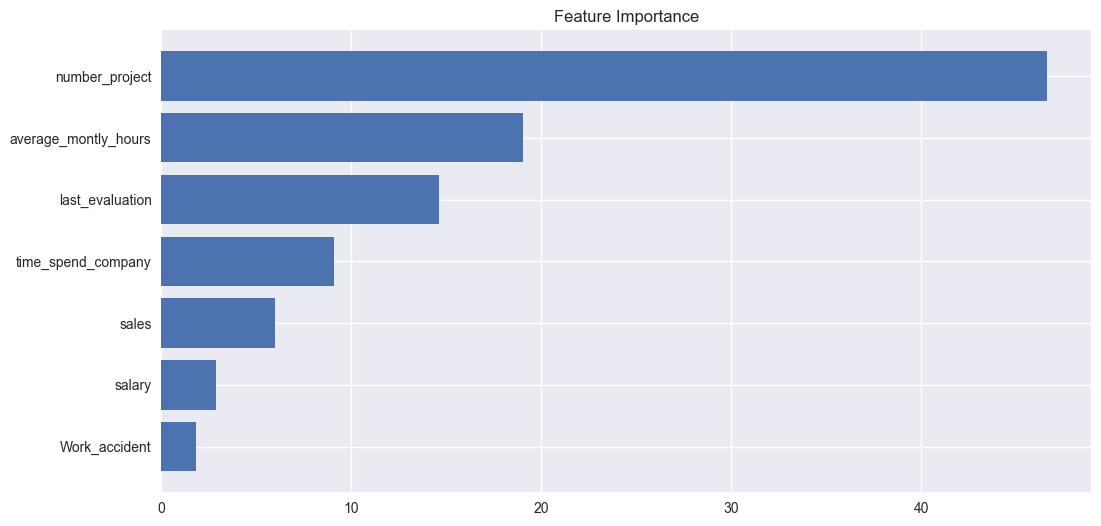

In [205]:
# Plotting feature importance

feature_importance = cat_model.feature_importances_
sorted_idx = np.argsort(feature_importance)

fig = plt.figure(figsize=(12, 6))
plt.barh(np.array(df_features)[sorted_idx], feature_importance[sorted_idx])
plt.title('Feature Importance')

# **BaggingRegressor**

In [ ]:
# RandomForest hyperparameters search using optuna

def objective(trial):
    # split data in training and test data
    X_train, X_test, y_train, y_test = train_test_split(df_encoded[df_encoded_features], df_encoded[target],
                                                        test_size=0.25,
                                                        random_state=777)

    # Instantiate scaler
    scalers = trial.suggest_categorical("scalers", ['minmax', 'standard', 'robust', 'maxabs', None])

    if scalers == "minmax":
        scaler = MinMaxScaler()
    elif scalers == "standard":
        scaler = StandardScaler()
    elif scalers == 'maxabs':
        scaler = MaxAbsScaler()
    elif scalers == 'robust':
        scaler = RobustScaler()
    else:
        scaler = None
    

    # Suggest hyperparameters
    param = { 
        "n_estimators": trial.suggest_int('n_estimators', 50, 1000),
        "max_depth": trial.suggest_int('max_depth', 10, 150),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
   } 
     
    rfr = RandomForestRegressor(
        random_state = 777,
        criterion = 'friedman_mse',
        **param)

    # Make a pipeline
    pipeline = make_pipeline(scaler, rfr)
    pipeline.fit(X_train, y_train)


    # Predict and estimate results
    preds = pipeline.predict(X_test)
    rmse = root_mean_squared_error(y_test, preds)

    return rmse

# Opruna study creation for tuning
sampler_br = TPESampler(multivariate = True, group = True, seed = 777)
study_br = optuna.create_study(study_name = "BR", sampler = sampler_br)
study_br.optimize(objective, n_trials = 150)
trial_br = study_br.best_trial
params_br = study_br.best_trial.params

# Printing the parameters
print("Number of finished trials: ", len(study_br.trials))
print("Best trial:", trial_br.number)
print("  Value: ", trial_br.value)
print("  Params: ")

for key, value in trial_br.params.items():
    print("    {}: {}".format(key, value))

[I 2024-05-19 23:41:49,685] A new study created in memory with name: RFR
[I 2024-05-19 23:42:05,204] Trial 0 finished with value: 0.17074813686866802 and parameters: {'scalers': None, 'n_estimators': 931, 'max_depth': 112, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.17074813686866802.
[I 2024-05-19 23:42:16,476] Trial 1 finished with value: 0.17090043803856325 and parameters: {'scalers': None, 'n_estimators': 645, 'max_depth': 106, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.17074813686866802.
[I 2024-05-19 23:42:54,998] Trial 2 finished with value: 0.17155806344955274 and parameters: {'scalers': None, 'n_estimators': 889, 'max_depth': 97, 'max_features': None}. Best is trial 0 with value: 0.17074813686866802.
[I 2024-05-19 23:42:56,152] Trial 3 finished with value: 0.17127297651233828 and parameters: {'scalers': 'maxabs', 'n_estimators': 62, 'max_depth': 83, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.17074813686866802.
[I 2024-05-19 23:43:06,515] Tria

Number of finished trials:  150
Best trial: 137
  Value:  0.17039856088432723
  Params: 
    scalers: minmax
    n_estimators: 890
    max_depth: 27
    max_features: log2


In [ ]:
# History of optimization

optuna.visualization.plot_optimization_history(study_br)

In [ ]:
# Hyperparameters to score dependency

optuna.visualization.plot_slice(study_br)

In [ ]:
# Hyperparameter importances

optuna.visualization.plot_param_importances(study_br)

In [ ]:
# Define optimal hyperparameters
del params_br['scalers']
scaler_br = MinMaxScaler()
br = BaggingRegressor(**params_br)

# Create pipeline
pipeline_br = make_pipeline(scaler_br, br)

In [ ]:
# Implementing cross validation

scores_br = cross_val_score(pipeline_br, df_encoded[df_encoded_features], df_encoded[target],  scoring = 'neg_root_mean_squared_error') * (-1)
score_mean_br = scores_br.mean()
print(scores_br, "Средняя оценка:", score_mean_br)

[0.1453414  0.20959767 0.20842707 0.16439386 0.06375362] Средняя оценка: 0.15830272347743563
